In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import pickle
import shap
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

# Load the cleaned data
df = pd.read_csv('cleaned_telecom_data.csv')

# Split the data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Load the saved model
with open('best_churn_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

print("Model loaded successfully")

c:\Users\HP\miniconda3\envs\every_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully


In [3]:
# Make predictions on the entire dataset
y_pred = best_model.predict(X)
y_proba = best_model.predict_proba(X)[:, 1]

# Calculate overall metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9901
Precision: 0.9870
Recall: 0.9441
F1 Score: 0.9651
ROC AUC: 0.9851


In [4]:
# Detailed classification report
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2850
           1       0.99      0.94      0.97       483

    accuracy                           0.99      3333
   macro avg       0.99      0.97      0.98      3333
weighted avg       0.99      0.99      0.99      3333



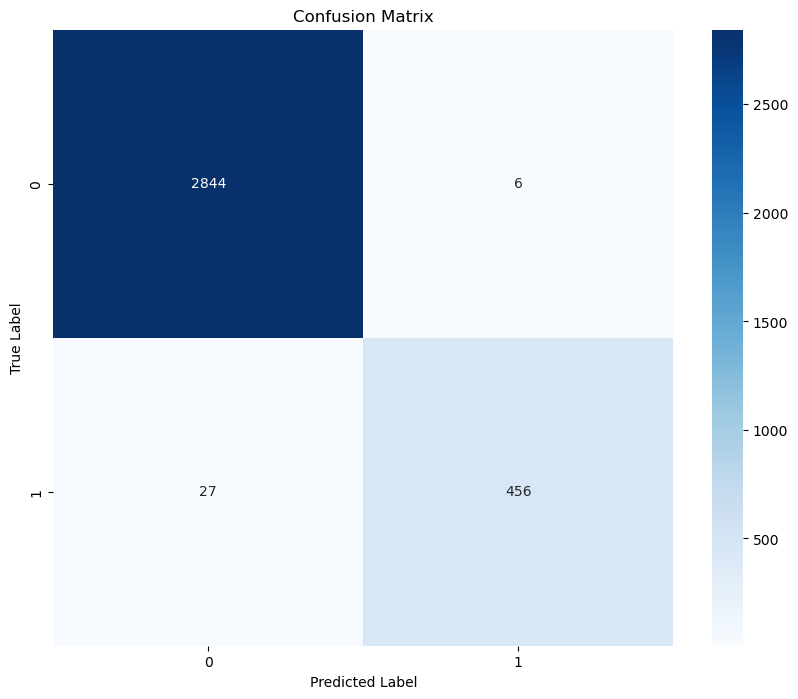

In [5]:
# Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

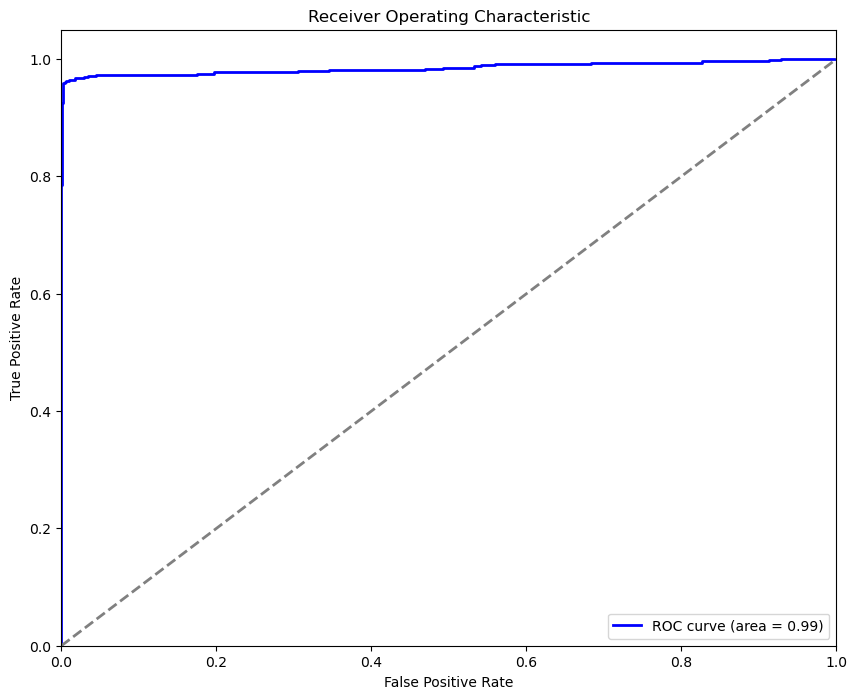

In [6]:
# ROC Curve
fpr, tpr, _ = roc_curve(y, y_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

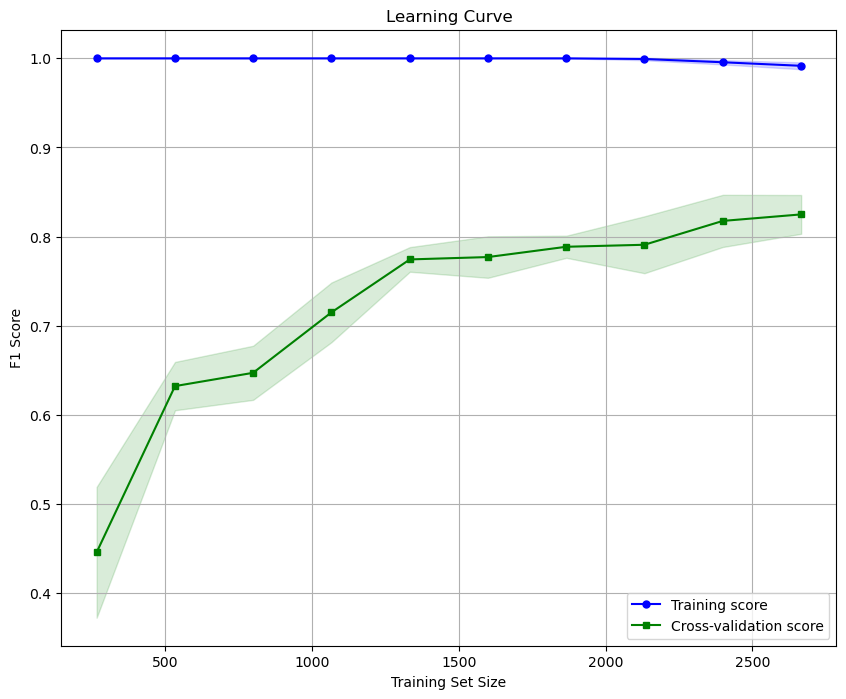

In [7]:
# Learning Curve to check for overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

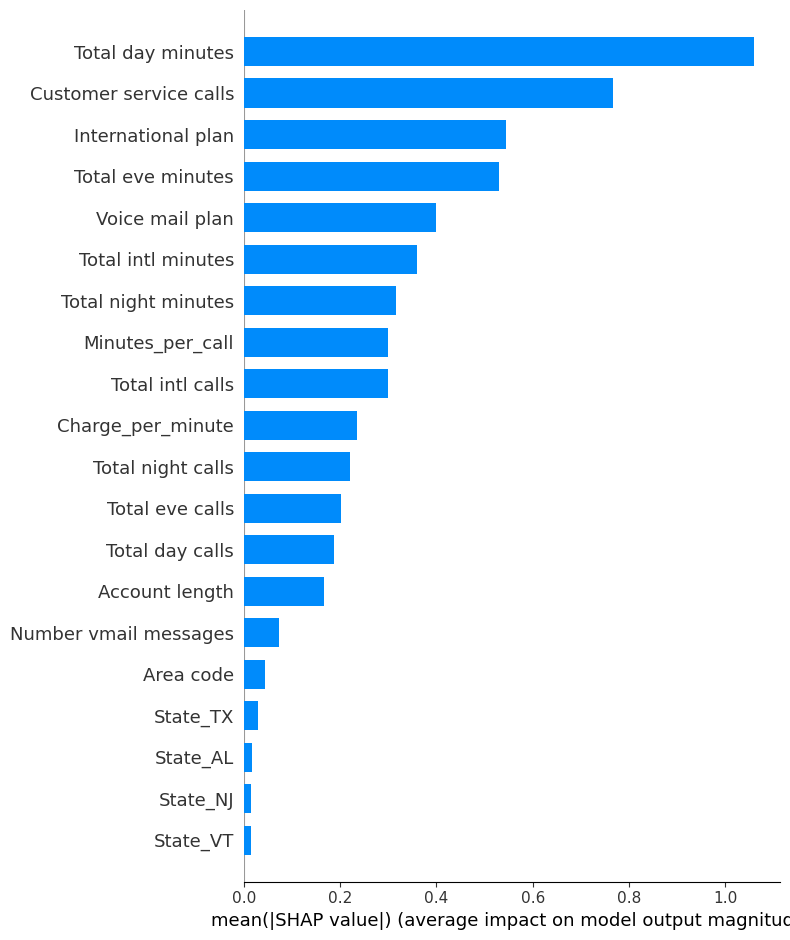

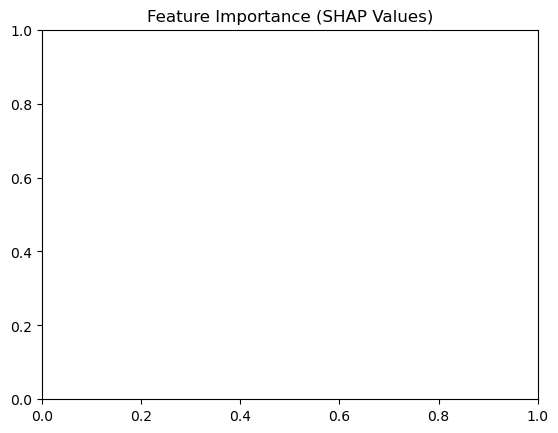

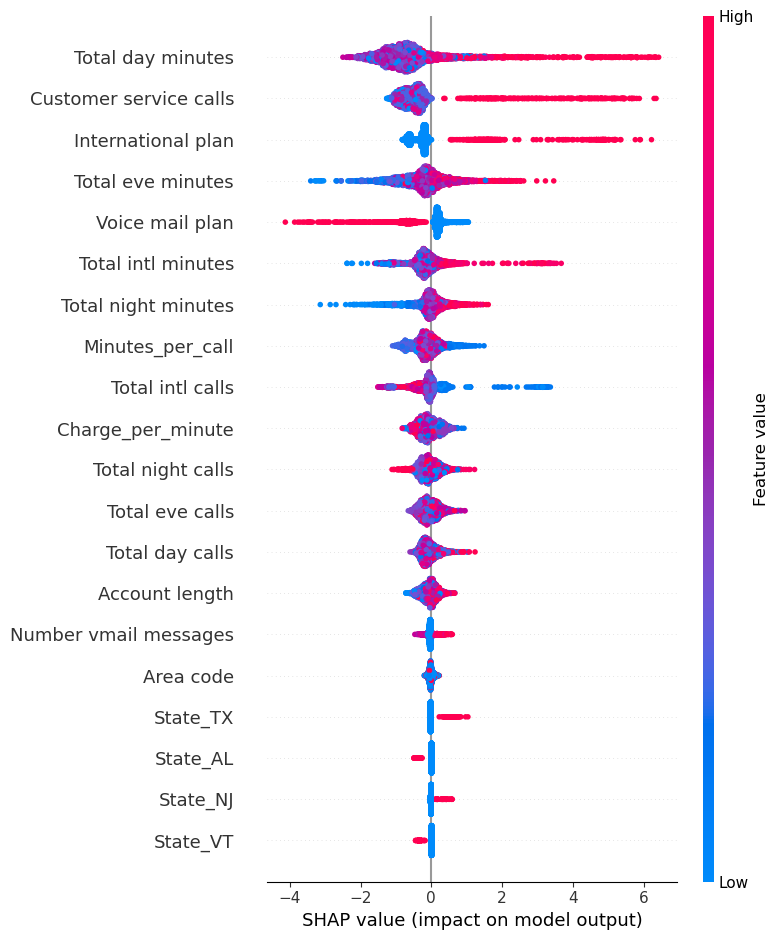

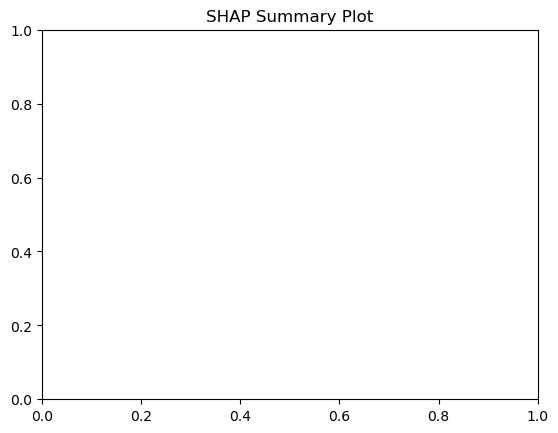

In [8]:
# SHAP values for model interpretability
# Create a SHAP explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

# Summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X, plot_type="bar")
plt.title('Feature Importance (SHAP Values)')
plt.show()

# Detailed SHAP plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X)
plt.title('SHAP Summary Plot')
plt.show()

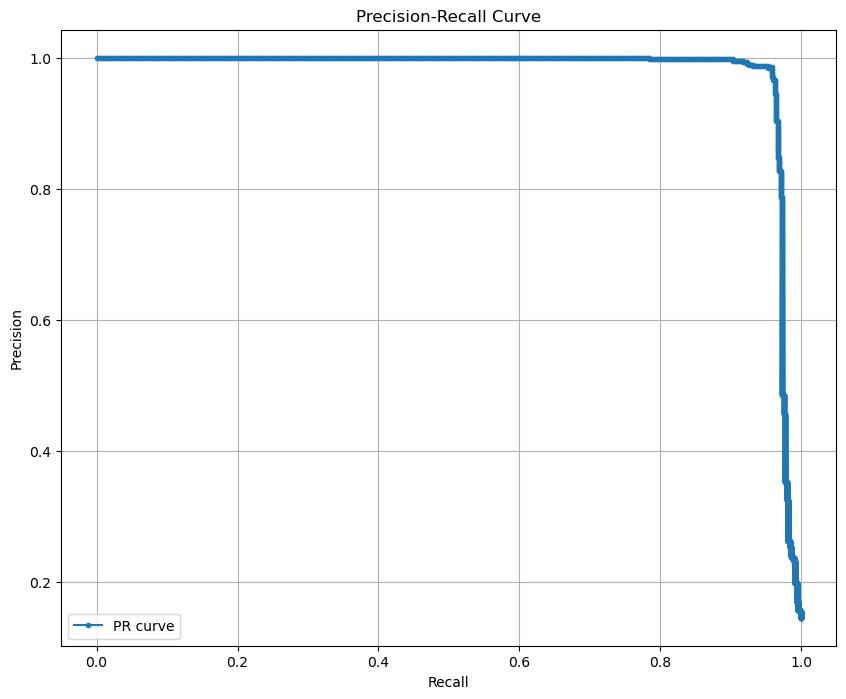

In [9]:
# Precision-Recall tradeoff
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, marker='.', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

   threshold  precision    recall        f1
0        0.1   0.858456  0.966874  0.909445
1        0.2   0.954825  0.962733  0.958763
2        0.3   0.968685  0.960663  0.964657
3        0.4   0.983015  0.958592  0.970650
4        0.5   0.987013  0.944099  0.965079
5        0.6   0.993289  0.919255  0.954839
6        0.7   0.997636  0.873706  0.931567
7        0.8   0.997462  0.813665  0.896237
8        0.9   1.000000  0.726708  0.841727


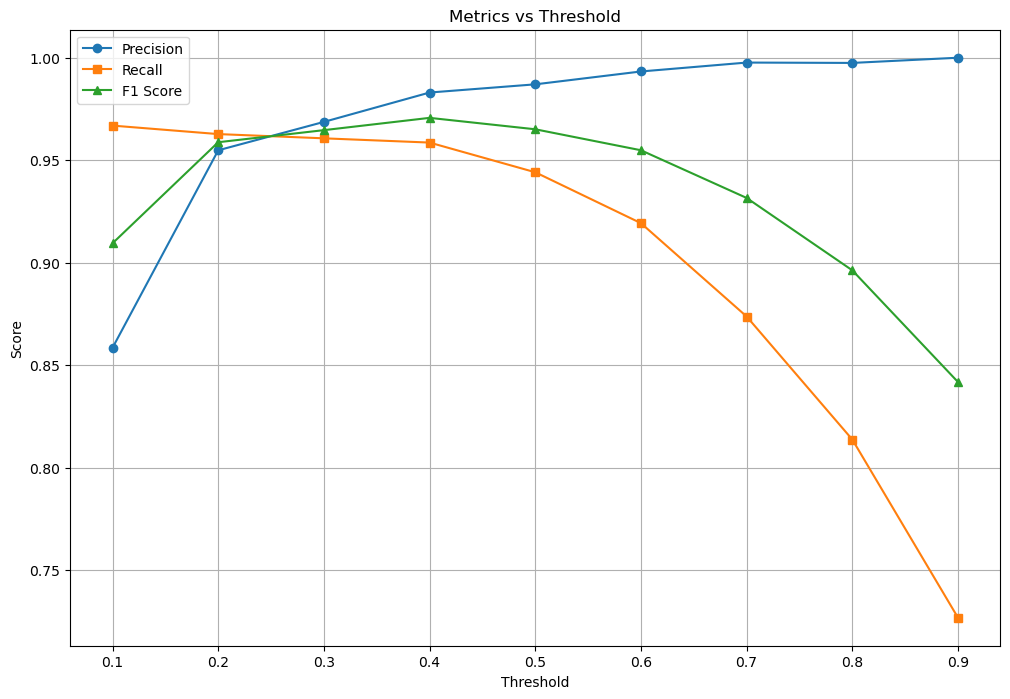

In [10]:
# Threshold analysis
thresholds = np.arange(0.1, 1.0, 0.1)
scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    
    precision = precision_score(y, y_pred_thresh)
    recall = recall_score(y, y_pred_thresh)
    f1 = f1_score(y, y_pred_thresh)
    
    scores.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

scores_df = pd.DataFrame(scores)
print(scores_df)

# Plot threshold vs metrics
plt.figure(figsize=(12, 8))
plt.plot(scores_df['threshold'], scores_df['precision'], marker='o', label='Precision')
plt.plot(scores_df['threshold'], scores_df['recall'], marker='s', label='Recall')
plt.plot(scores_df['threshold'], scores_df['f1'], marker='^', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Business impact analysis
# Calculate the cost-benefit of the model
# Assuming:
# - Cost of losing a customer (false negative): $500
# - Cost of retention campaign (false positive): $50

cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

cost_without_model = len(y[y == 1]) * 500  # All churners lost
cost_with_model = (fn * 500) + (fp * 50)  # False negatives + False positives
savings = cost_without_model - cost_with_model

print(f"Cost without model: ${cost_without_model}")
print(f"Cost with model: ${cost_with_model}")
print(f"Savings: ${savings}")
print(f"ROI: {savings / cost_with_model:.2f}x")

Cost without model: $241500
Cost with model: $13800
Savings: $227700
ROI: 16.50x


In [12]:
# Final model evaluation summary
print("Final Model Evaluation Summary")
print("==============================")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nTop 5 Most Important Features:")
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    for i in range(5):
        print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]:.4f}")
print("\nBusiness Impact:")
print(f"Predicted savings: ${savings}")
print(f"ROI: {savings / cost_with_model:.2f}x")

Final Model Evaluation Summary
Accuracy: 0.9901
Precision: 1.0000
Recall: 0.7267
F1 Score: 0.8417
ROC AUC: 0.9851

Top 5 Most Important Features:
1. International plan: 0.1473
2. Customer service calls: 0.1194
3. Voice mail plan: 0.1155
4. Total day minutes: 0.1030
5. Total intl minutes: 0.0595

Business Impact:
Predicted savings: $227700
ROI: 16.50x
